In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import pickle

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
# 2. Initial cleaning
# Drop ID
if 'id' in df.columns:
    df.drop(columns='id', inplace=True)
# Replace 'Unknown' with NaN
df['smoking_status'].replace('Unknown', np.nan, inplace=True)
df

C:\Users\Rexon_Pambujya\AppData\Local\Temp\ipykernel_21084\920281990.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['smoking_status'].replace('Unknown', np.nan, inplace=True)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [6]:
# 3. Imputation
imp_mean = SimpleImputer(strategy='mean')
df['bmi'] = imp_mean.fit_transform(df[['bmi']])
# Impute smoking with mode
df['smoking_status'].fillna(df['smoking_status'].mode()[0], inplace=True)

C:\Users\Rexon_Pambujya\AppData\Local\Temp\ipykernel_21084\3926993264.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['smoking_status'].fillna(df['smoking_status'].mode()[0], inplace=True)


In [7]:
# 4. Train-test split (raw)
X = df.drop(columns='stroke')
y = df['stroke']
X_train_raw, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [8]:
# === Pipeline A: Logistic Regression ===
# 5A. One-hot encoding + scaling
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

In [10]:
# Fit OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False)
X_train_ohe = ohe.fit_transform(X_train_raw[categorical_cols])
X_val_ohe = ohe.transform(X_val_raw[categorical_cols])

In [11]:
# Scale numeric
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_raw[num_cols])
X_val_num = scaler.transform(X_val_raw[num_cols])


In [13]:
# Combine
X_train_lr = np.hstack([X_train_num, X_train_ohe])
X_val_lr = np.hstack([X_val_num, X_val_ohe])

In [14]:
# 6A. Train LR with balanced class weight
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_lr, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [28]:
# Evaluate
from sklearn.metrics import precision_score, recall_score
print("Logistic Regression (Balanced)")
y_pred_lr = lr.predict(X_val_lr)
y_proba_lr = lr.predict_proba(X_val_lr)[:, 1]
thresholds = np.linspace(0, 1, 1001)
precisions = []
recalls = []
for threshold in thresholds:
    y_pred_t = (y_proba_lr >= threshold).astype(int)
    precisions.append(precision_score(y_val, y_pred_t))
    recalls.append(recall_score(y_val, y_pred_t))

print(classification_report(y_val, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_val, y_proba_lr))

Logistic Regression (Balanced)


C:\Users\Rexon_Pambujya\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Rexon_Pambujya\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Rexon_Pambujya\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

              precision    recall  f1-score   support

           0       0.99      0.71      0.82       972
           1       0.12      0.80      0.21        50

    accuracy                           0.71      1022
   macro avg       0.55      0.75      0.52      1022
weighted avg       0.94      0.71      0.79      1022

ROC AUC: 0.8370987654320988


C:\Users\Rexon_Pambujya\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Rexon_Pambujya\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
from sklearn.metrics import precision_recall_curve

# 1. Compute PR curve points
prec, rec, thr = precision_recall_curve(y_val, y_proba_lr)

# 2. Find the smallest threshold with recall ≥ 0.90
target_recall = 0.90
idx = np.where(rec >= target_recall)[0]
best_idx = idx[0]            # first index meeting the criterion
best_threshold = thr[best_idx]

print(f"Chosen threshold → {best_threshold:.3f}")
print(f"At this threshold: Precision = {prec[best_idx]:.3f}, Recall = {rec[best_idx]:.3f}")


Chosen threshold → 0.001
At this threshold: Precision = 0.049, Recall = 1.000


In [35]:
from sklearn.metrics import precision_recall_curve

# 1. Compute the PR‐curve
prec, rec, thr = precision_recall_curve(y_val, y_proba_lr)

# 2. Mask only those thresholds where recall ≥ 0.90
target_recall = 0.90
mask = (rec >= target_recall)

# 3. Among those, pick the *largest* threshold (not the smallest!)
valid_thresholds = thr[mask[:-1]]  
# Note: thr has length = len(rec)-1, so we drop the last rec point

if len(valid_thresholds) == 0:
    # fallback if nothing meets the bar
    best_threshold = thr[0]
else:
    best_threshold = valid_thresholds.max()

# 4. Check performance
y_pred_sel = (y_proba_lr >= best_threshold).astype(int)
from sklearn.metrics import precision_score, recall_score
print(f"Chosen threshold → {best_threshold:.3f}")
print("Precision:", precision_score(y_val, y_pred_sel))
print("Recall:   ", recall_score(y_val, y_pred_sel))


Chosen threshold → 0.284
Precision: 0.0967741935483871
Recall:    0.9


In [37]:
# Combine train + val for final fit
X_full_lr = np.vstack([X_train_lr, X_val_lr])
y_full_lr = np.concatenate([y_train, y_val])

# Re‑fit
lr_final = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_final.fit(X_full_lr, y_full_lr)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [38]:
import pickle

with open("lr_stroke_pipeline.pkl", "wb") as f:
    pickle.dump({
        "model": lr_final,
        "scaler": scaler,
        "onehot": ohe,
        "num_cols": num_cols,
        "cat_cols": categorical_cols,
        "threshold": 0.284
    }, f)


In [39]:
def predict_stroke(df_new, pipeline_path="lr_stroke_pipeline.pkl"):
    # 1. Load pipeline
    data = pickle.load(open(pipeline_path, "rb"))
    model, scaler, ohe = data["model"], data["scaler"], data["onehot"]
    num_cols, cat_cols = data["num_cols"], data["cat_cols"]
    thresh = data["threshold"]
    
    # 2. Preprocess
    X_num = scaler.transform(df_new[num_cols])
    X_ohe = ohe.transform(df_new[cat_cols])
    X_proc = np.hstack([X_num, X_ohe])
    
    # 3. Predict
    proba = model.predict_proba(X_proc)[:, 1]
    pred = (proba >= thresh).astype(int)
    return pred, proba

# Example:
# df_sample = pd.DataFrame({...})
# labels, probabilities = predict_stroke(df_sample)


In [40]:
# Preprocess test same as above
X_test_num = scaler.transform(X_test_raw[num_cols])
X_test_ohe = ohe.transform(X_test_raw[categorical_cols])
X_test_lr = np.hstack([X_test_num, X_test_ohe])

y_test_pred, y_test_proba = predict_stroke(
    X_test_raw, pipeline_path="lr_stroke_pipeline.pkl"
)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)


              precision    recall  f1-score   support

           0       0.99      0.59      0.73       972
           1       0.09      0.84      0.17        50

    accuracy                           0.60      1022
   macro avg       0.54      0.71      0.45      1022
weighted avg       0.94      0.60      0.71      1022



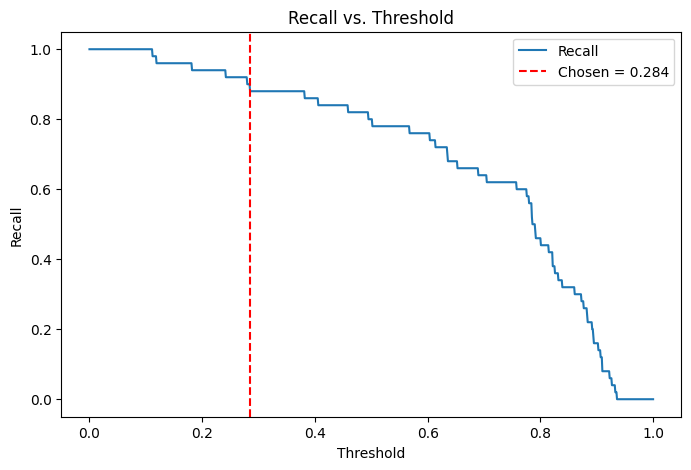

In [36]:
plt.figure(figsize=(8,5))
plt.plot(thresholds, recalls, label="Recall")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Chosen = {best_threshold:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall vs. Threshold")
plt.legend()
plt.show()


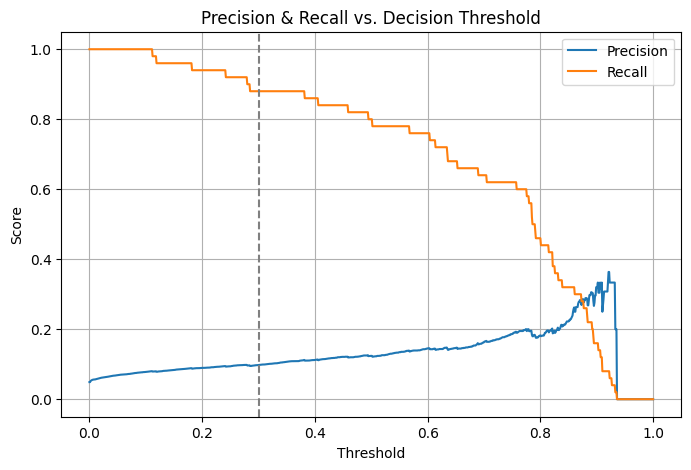

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.axvline(0.3, color="grey", linestyle="--")  # e.g. chosen threshold
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs. Decision Threshold")
plt.legend()
plt.grid(True)
plt.show()


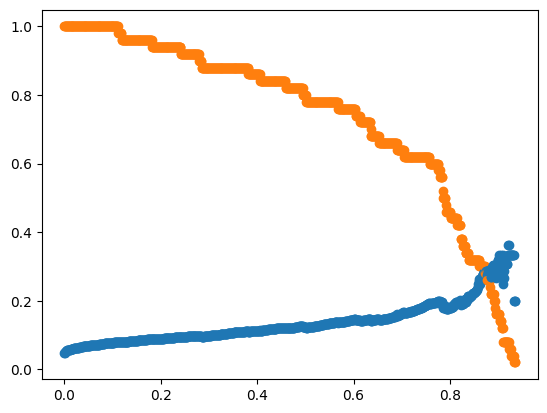

In [32]:
for t, p, r in zip(thresholds, precisions, recalls):
    if (p+r) > 0:   # only plot when at least one positive is predicted
        plt.scatter(t, p, color='C0')
        plt.scatter(t, r, color='C1')

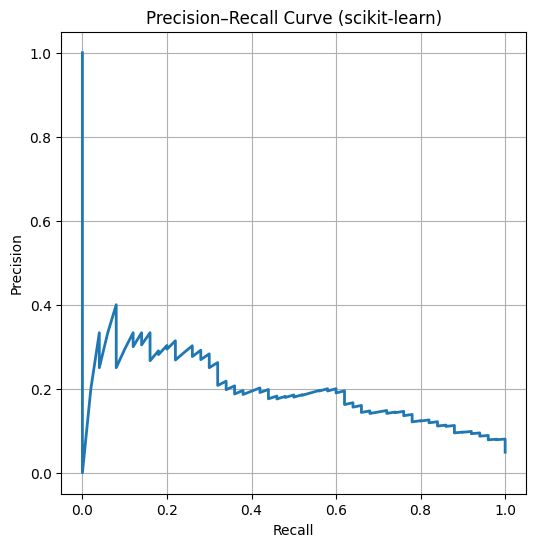

In [30]:
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_val, y_proba_lr)

plt.figure(figsize=(6,6))
plt.plot(rec, prec, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (scikit‑learn)")
plt.grid(True)
plt.show()


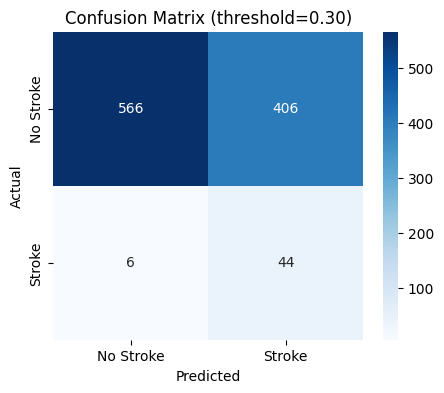

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

t = 0.3  # your new cutoff
y_pred_t = (y_proba_lr >= t).astype(int)
cm = confusion_matrix(y_val, y_pred_t)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Stroke","Stroke"],
            yticklabels=["No Stroke","Stroke"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (threshold={t:.2f})")
plt.show()


In [16]:
# === Pipeline B: RandomForest & XGBoost ===
# 5B. Label encode categoricals
X_train_rf = X_train_raw.copy()
X_val_rf = X_val_raw.copy()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train_rf[col] = le.fit_transform(X_train_rf[col].astype(str))
    X_val_rf[col] = le.transform(X_val_rf[col].astype(str))
    label_encoders[col] = le

In [17]:
# 6B. Optional: SMOTE on training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_rf, y_train)

In [18]:
# 7B. Train RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)
print("Random Forest (SMOTE)")
y_pred_rf = rf.predict(X_val_rf)
y_proba_rf = rf.predict_proba(X_val_rf)[:, 1]
print(classification_report(y_val, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_val, y_proba_rf))


Random Forest (SMOTE)
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       972
           1       0.10      0.16      0.12        50

    accuracy                           0.89      1022
   macro avg       0.53      0.54      0.53      1022
weighted avg       0.91      0.89      0.90      1022

ROC AUC: 0.7546399176954732


In [19]:
# 8B. Train XGBoost with scale_pos_weight
scale_pos = y_train.value_counts()[0] / y_train.value_counts()[1]
xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos,
    random_state=42
)
xgb.fit(X_train_res, y_train_res)
print("XGBoost (SMOTE + scale_pos_weight)")
y_pred_xgb = xgb.predict(X_val_rf)
y_proba_xgb = xgb.predict_proba(X_val_rf)[:, 1]
print(classification_report(y_val, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_val, y_proba_xgb))


XGBoost (SMOTE + scale_pos_weight)
              precision    recall  f1-score   support

           0       0.97      0.81      0.88       972
           1       0.12      0.48      0.19        50

    accuracy                           0.80      1022
   macro avg       0.54      0.65      0.54      1022
weighted avg       0.93      0.80      0.85      1022

ROC AUC: 0.7821604938271605


C:\Users\Rexon_Pambujya\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [01:05:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
